In [1]:
#data format library
import h5py
#numpy
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
# %matplotlib notebook
from sklearn.cluster import KMeans

import sys
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as colors
import os
from scipy.integrate import odeint
sys.path.append('/Users/costa/Repositories/max_pred_states_repo+data/maximally_predictive_states/utils')
import operator_calculations as op_calc
import stats

In [2]:
#change path to where 'manuscript_data' is saved
dir_path = '/Users/costa/Repositories/max_pred_states_repo+data/manuscript_data/'

In [3]:
r_range = np.arange(3.5,3.99,.01)
K_range = np.arange(1,13)
cluster_range=np.unique(np.array(np.logspace(2,3.5,3),dtype=int))
n_samples=100
h_r_K = np.zeros((len(r_range),len(K_range),n_samples,len(cluster_range)))
lyap_r = np.zeros((len(r_range),len(K_range)))
for kr,r in enumerate(r_range):
    for k,K in enumerate(K_range):
        f = h5py.File(dir_path+'KS_entropy/Logistic/h_r_{:.4f}_K_{}.h5'.format(r,K),'r')
        h_source = np.array(f['h_source'])
        mD = f['MetaData']
        K = np.array(mD['K'])[0]
        cluster_range = np.array(mD['cluster_range'])
        l = np.array(f['lyap'])[0]
        f.close()
        h_r_K[kr,k] = h_source
        lyap_r[kr,k] = l

In [4]:
h_estim = np.zeros((len(r_range),2))
for kr,r in enumerate(r_range):
    h_K = (h_r_K[kr].T/K_range)
    h_K_mean = h_K.mean(axis=1)
    h_K_std = h_K.std(axis=1)
    max_idx = np.argmax(h_K_mean,axis=0)
    y = np.array([h_K_mean[idx,k] for k,idx in enumerate(max_idx)])
    idx_min = ma.argmin(-ma.diff(y)/ma.diff(K_range))
    h_mean = y[idx_min]
    y_std = np.array([h_K_std[idx,k] for k,idx in enumerate(max_idx)])
    h_std = y_std[idx_min]
    h_estim[kr,0] = h_mean
    h_estim[kr,1] = h_std

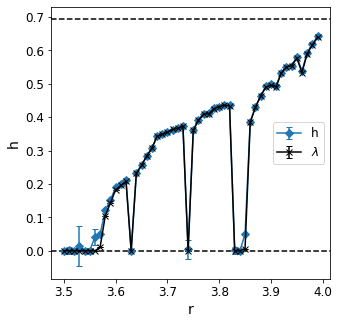

In [11]:
plt.figure(figsize=(5,5))
h_lyap = lyap_r.mean(axis=1)
h_lyap[h_lyap<0]=0
h_lyap_std = lyap_r.std(axis=1)
plt.errorbar(r_range,h_estim[:,0],yerr=h_estim[:,1],marker='D',label='h',capsize=3)
plt.errorbar(r_range,h_lyap,h_lyap_std,c='k',marker='x',capsize=3,label='$\lambda$')
plt.axhline(np.log(2),c='k',ls='--')
plt.axhline(0,c='k',ls='--')
plt.legend(fontsize=12)
plt.xlabel('r',fontsize=14)
plt.ylabel('h',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.savefig('entropy_lyap.pdf')
plt.show()

In [6]:
h_K_all = np.zeros((len(K_range),len(r_range),3))
h_K_std = np.zeros((len(K_range),len(r_range),2))
for kr,r in enumerate(r_range):
    h_K = (h_r_K[kr].T/K_range)
    h_K_mean = h_K.mean(axis=1)
    h_K_std_ = h_K.std(axis=1)
    h_K_cil = np.percentile(h_K,2.5,axis=1)
    h_K_ciu = np.percentile(h_K,97.5,axis=1)
    max_idx = np.argmax(h_K_mean,axis=0)
    y = np.array([h_K_mean[idx,k] for k,idx in enumerate(max_idx)])
    y_std = np.array([h_K_std_[idx,k] for k,idx in enumerate(max_idx)])
    y_cil = np.array([h_K_cil[idx,k] for k,idx in enumerate(max_idx)])
    y_ciu = np.array([h_K_ciu[idx,k] for k,idx in enumerate(max_idx)])
    h_K_all[:,kr,0] = y
    h_K_all[:,kr,1] = y_cil
    h_K_all[:,kr,2] = y_ciu
    h_K_std[:,kr,0] = y
    h_K_std[:,kr,1] = y_std

In [7]:
kr_plot_indices = [0,10,30,34]
colors_r = plt.cm.viridis(np.linspace(0,.7,len(kr_plot_indices)))
markers=['o','s','v','X']

# FigS7a

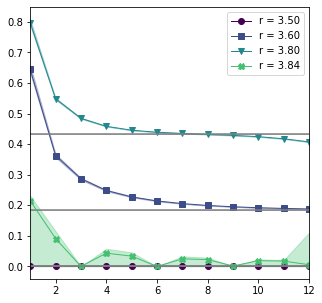

In [8]:
plt.figure(figsize=(5,5))
for kr_,kr in enumerate(kr_plot_indices):
    plt.plot(K_range,h_K_all[:,kr,0],label='r = {:.2f}'.format(r_range[kr]),lw=1,marker=markers[kr_],c=colors_r[kr_])
    plt.fill_between(K_range,h_K_all[:,kr,1],h_K_all[:,kr,2],alpha=.3,color=colors_r[kr_])
    plt.axhline(h_lyap[kr],c='gray')
    plt.axhspan(h_lyap[kr]-h_lyap_std[kr],h_lyap[kr]+h_lyap_std[kr],color='gray',alpha=.5)
plt.legend()
plt.xlim(1,12)
# plt.savefig('h_K_examples.pdf')
plt.show()

In [9]:
kr=kr_plot_indices[2]
h_K = (h_r_K[kr].T/K_range)
h_K_mean = h_K.mean(axis=1)
h_K_std = h_K.std(axis=1)
h_K_cil = np.percentile(h_K,2.5,axis=1)
h_K_ciu = np.percentile(h_K,97.5,axis=1)
h_K_diff = -np.diff((h_r_K[kr].T/K_range),axis=2)
max_idx = np.argmax(h_K_mean,axis=0).max()
h_K_diff_mean = h_K_diff.mean(axis=1)[max_idx]
h_K_diff_cil = np.percentile(h_K_diff,2.5,axis=1)[max_idx]
h_K_diff_ciu = np.percentile(h_K_diff,97.5,axis=1)[max_idx]

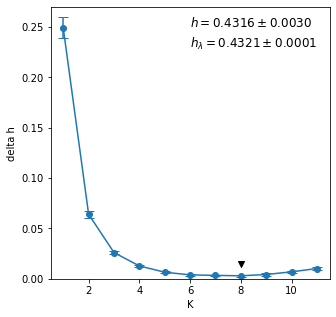

In [10]:
plt.figure(figsize=(5,5))
plt.errorbar(K_range[:-1],h_K_diff_mean,yerr = [h_K_diff_mean-h_K_diff_cil,h_K_diff_ciu-h_K_diff_mean],capsize=5,marker='o')
idx = np.argmin(h_K_diff_mean)
plt.scatter(K_range[idx],h_K_diff_mean[idx]*5,marker='v',c='k')
plt.text(6,.25,'$h = {:.4f}\pm {:.4f}$'.format(h_K_mean[max_idx,idx],h_K_std[max_idx,idx]),fontsize=12)
plt.text(6,.23,'$h_\lambda = {:.4f}\pm {:.4f}$'.format(h_lyap[kr],h_lyap_std[kr]),fontsize=12)
# plt.axhline(0,c='k')
plt.ylim(0,0.27)
plt.ylabel('delta h')
plt.xlabel('K')
# plt.savefig('entropy_diff_Logistic_map_example.pdf')
plt.show()